In [1]:
import numpy as np
from PySDM.physics.constants import si
from PySDM_examples.Luettmer_homogeneous_freezing.commons import run_simulations, hom_pure_droplet_freezing_backend, hom_pure_droplet_freezing_standard_setup
from PySDM_examples.Luettmer_homogeneous_freezing import plot
from importlib import reload
from matplotlib import pyplot
from open_atmos_jupyter_utils import show_plot

In [2]:
# """ General settings """
hom_freezing_types     = [  "KoopMurray2016", "Spichtinger2023" ]
hom_freezing_types_all = [  "KoopMurray2016", "Spichtinger2023", "Koop2000"  ]
number_of_nsd = (1e1, 1e2, 1e3)
vertical_updrafts = np.geomspace(0.2,10,num=9) * si.meter / si.second
number_concentrations = np.geomspace(100, 20000, num=10) / si.cm ** 3

backends = hom_pure_droplet_freezing_backend()
standard = hom_pure_droplet_freezing_standard_setup()

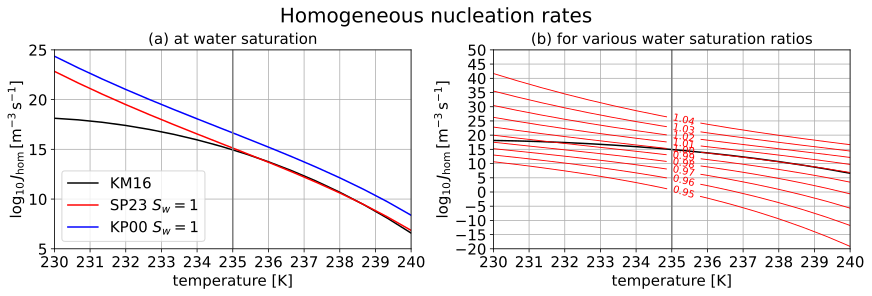

In [5]:
# Fig. 1 - homogeneous nucleation rates
def d_aw_ice(S_i,pv_sat_w,pv_sat_i):
    return (S_i - 1) * pv_sat_i / pv_sat_w

# backends setup
formulae = backends["KoopMurray2016"].formulae
KM16_rate_formulae = backends["KoopMurray2016"].formulae.homogeneous_ice_nucleation_rate.j_hom
SP23_rate_formulae = backends["Spichtinger2023"].formulae.homogeneous_ice_nucleation_rate.j_hom
KP00_rate_formulae = backends["Koop2000"].formulae.homogeneous_ice_nucleation_rate.j_hom

# Set temperature and saturation ratio wtr water
fig1_T = np.linspace(230, 240, num=16) * si.K
fig1_s_w = np.linspace(0.95,1.05,num=11)
T_mesh, s_w_mesh = np.meshgrid( fig1_T, fig1_s_w)
pv_sat_w = formulae.saturation_vapour_pressure.pvs_water(T_mesh) * si.Pa
pv_sat_i = formulae.saturation_vapour_pressure.pvs_ice(T_mesh) * si.Pa
s_i_mesh = s_w_mesh * pv_sat_w / pv_sat_i
d_aw_i_mesh   = d_aw_ice(s_i_mesh,pv_sat_w,pv_sat_i)

# Calculate rates
rates_KM16 = np.log10(KM16_rate_formulae( T_mesh, d_aw_i_mesh ))
rates_SP23 = np.log10(SP23_rate_formulae( T_mesh, d_aw_i_mesh ))
rates_KP00 = np.log10(KP00_rate_formulae( T_mesh, d_aw_i_mesh ))

# plot settings
ax_title_size = 18
ax_lab_fsize = 15
tick_fsize = 15

fig, axs = pyplot.subplots(1, 2, figsize=(12, 4), constrained_layout=True)
fig.suptitle("Homogeneous nucleation rates",fontsize=20)

axs = axs.ravel()

idx = np.where(fig1_s_w == 1)[0]
axs[0].plot(T_mesh[idx,:][0], rates_KM16[idx,:][0], color="black", label="KM16")
axs[1].plot(T_mesh[idx,:][0], rates_KM16[idx,:][0], color="black")
axs[0].plot(T_mesh[idx,:][0], rates_SP23[idx,:][0], color="red", label=r"SP23 $S_{w}=1$")
axs[0].plot(T_mesh[idx,:][0], rates_KP00[idx,:][0],  color="blue", label=r"KP00 $S_{w}=1$")

levels = fig1_s_w.copy()
CS = axs[1].contour(
    T_mesh,
    rates_SP23,
    s_w_mesh,
    levels=levels,
    colors="red",
    linewidths=0.9
)
axs[1].clabel(CS, fmt=lambda v: f"{v:.2f}", inline=True, fontsize=10)

axs[0].set_title( r"(a) at water saturation", fontsize=ax_lab_fsize  )
axs[1].set_title( r"(b) for various water saturation ratios", fontsize=ax_lab_fsize  )
axs[0].legend(loc="lower left",fontsize=ax_lab_fsize)
axs[0].set_ylim(5,25)
axs[1].set_ylim(-20,50)

for ax in axs:
    ax.set_xlim(230,240)
    ax.set_xlabel(r"temperature [K]",fontsize=ax_lab_fsize)
    xticks = np.arange(230, 241, 1)
    ax.set_xticks(xticks)
    ax.tick_params(axis='both', labelsize=tick_fsize)
    ax.set_yticks(np.arange(ax.get_ylim()[0], ax.get_ylim()[1] + 1, 5))
    ax.set_ylabel(r"$\log_{10} J_{\mathrm{hom}}\,[\mathrm{m^{-3}\,s^{-1}}]$", fontsize=ax_lab_fsize)
    ax.grid(visible=True)
    ax.vlines(235, -20, 50, color="gray")
show_plot("fig_1")

In [28]:
# Fig 2 - example
setting_dict = {
            **standard,
            "backend": backends["KoopMurray2016"],
            "hom_freezing": "KoopMurray2016",
            "w_updraft": 2.5 * si.meter / si.second,
            "deposition_enable": False,
            "n_output": 1
            }
KoopMurray2016_reference_high_w_simulation = run_simulations(setting_dict)

setting_dict = {
            **standard,
            "backend": backends["Spichtinger2023"],
            "hom_freezing": "Spichtinger2023",
            "w_updraft": 2.5 * si.meter / si.second,
            "deposition_enable": False,
            "n_output": 1,
            }
Spichtinger2023_reference_high_w_simulation = run_simulations(setting_dict)



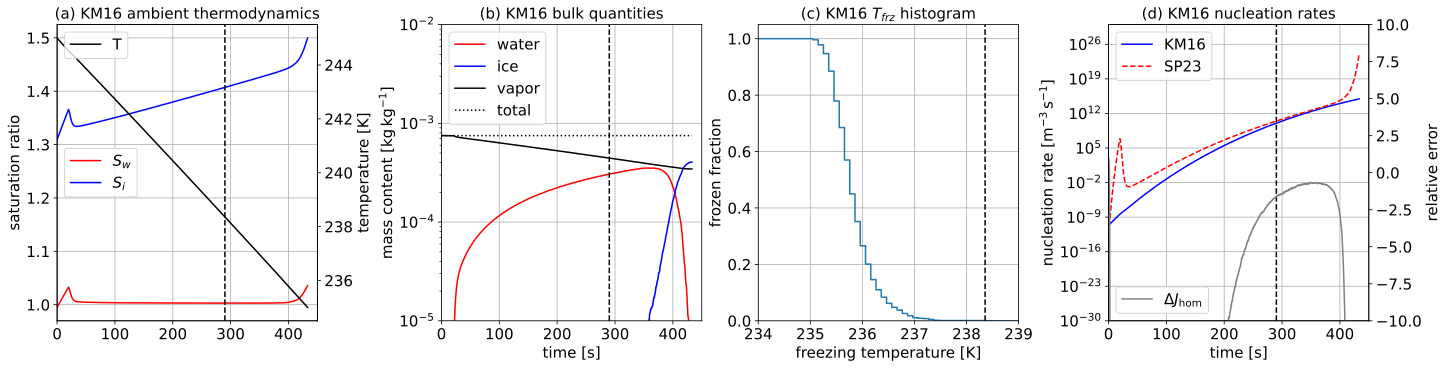

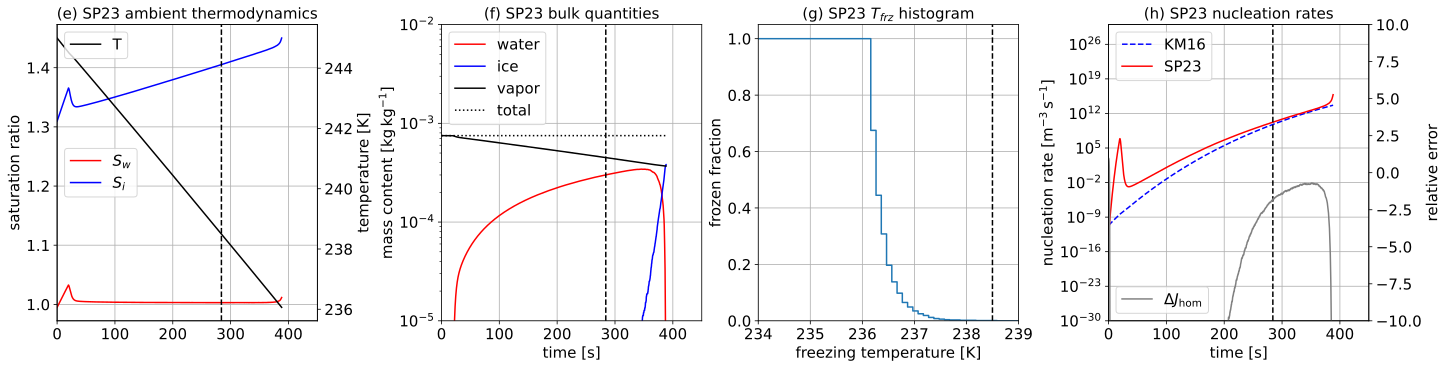

In [33]:
reload(plot)
panel_labels = ["(a)", "(b)", "(c)", "(d)"]
frz_label = " KM16 "
panel_labels = [label + frz_label for label in panel_labels]
plot.plot_thermodynamics_and_bulk(KoopMurray2016_reference_high_w_simulation, title_add=panel_labels, t_lim=450.)
show_plot("fig_21")

panel_labels = ["(e)", "(f)", "(g)", "(h)"]
frz_label = " SP23 "
panel_labels = [label + frz_label for label in panel_labels]
plot.plot_thermodynamics_and_bulk(Spichtinger2023_reference_high_w_simulation, title_add=panel_labels, t_lim=450.)
show_plot("fig_22")

In [6]:
#  Simulations for n_sd ensemble without deposition
nsd_ensemble_no_deposition = {}
nsd_ensemble_no_deposition["ens_variable"] = number_of_nsd
nsd_ensemble_no_deposition["ens_variable_name"] = "n_sd"
nsd_ensemble_no_deposition["hom_freezing_types"] = hom_freezing_types

for hom_freezing_type in hom_freezing_types:
    nsd_ensemble_no_deposition[hom_freezing_type] = []
    for n_sd in number_of_nsd:
        setting_dict = {
            **standard,
            "n_sd": int(n_sd),
            "backend": backends[hom_freezing_type],
            "hom_freezing": hom_freezing_type,
            "number_of_ensemble_runs": 5,
            "deposition_enable": False,
            }
        nsd_ensemble_no_deposition[hom_freezing_type].append( run_simulations(setting_dict) )

In [7]:
# Updraft ensemble simulations without deposition
updraft_ensemble_no_deposition = {}
updraft_ensemble_no_deposition["ens_variable"] = vertical_updrafts
updraft_ensemble_no_deposition["ens_variable_name"] = "w_updraft"
updraft_ensemble_no_deposition["hom_freezing_types"] = hom_freezing_types

for hom_freezing_type in hom_freezing_types:
    updraft_ensemble_no_deposition[hom_freezing_type] = []
    for updraft in vertical_updrafts:
        setting_dict = {
            **standard,
            "w_updraft": updraft  * si.meter / si.second,
            "backend": backends[hom_freezing_type],
            "hom_freezing": hom_freezing_type,
            "deposition_enable": False,
            }
        updraft_ensemble_no_deposition[hom_freezing_type].append( run_simulations(setting_dict) )

In [8]:
# Simulations for CCN concentration histogram
ccn_ensemble_no_deposition = {}
ccn_ensemble_no_deposition["ens_variable"] = number_concentrations
ccn_ensemble_no_deposition["ens_variable_name"] = "n_ccn"
ccn_ensemble_no_deposition["hom_freezing_types"] = hom_freezing_types

for hom_freezing_type in hom_freezing_types:
    ccn_ensemble_no_deposition[hom_freezing_type] = []
    for n_ccn in number_concentrations:
        setting_dict = {
            **standard,
            "n_ccn": n_ccn,
            "backend": backends[hom_freezing_type],
            "hom_freezing": hom_freezing_type,
            "deposition_enable": False,
        }
        ccn_ensemble_no_deposition[hom_freezing_type].append(run_simulations(setting_dict))

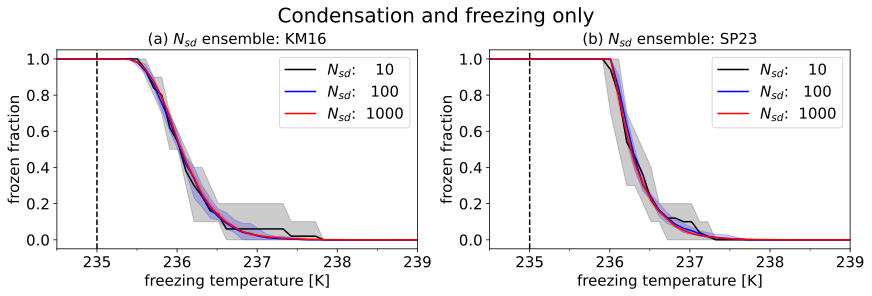

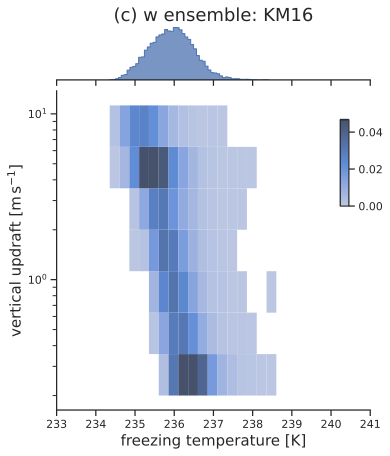

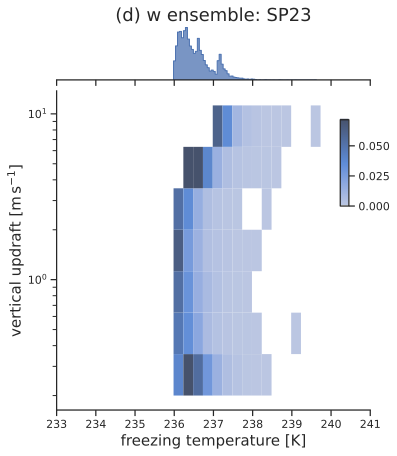

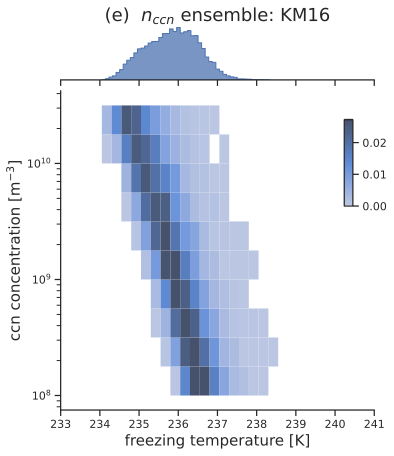

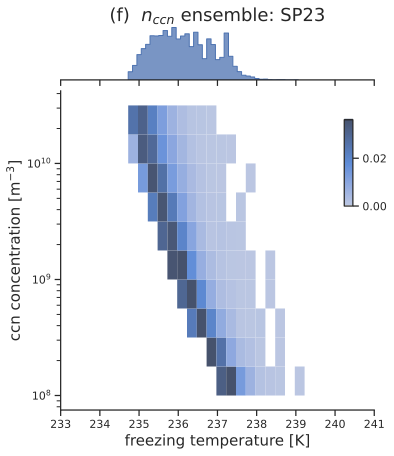

In [9]:
# Figure 3
reload(plot)
fig_id="fig3_"
fig, axs = pyplot.subplots(1, 2, figsize=(12, 4), constrained_layout=True)
fig.suptitle("Condensation and freezing only",fontsize=20)

axs = axs.ravel()

axs[0] = plot.plot_freezing_temperatures_histogram_allinone(axs[0], nsd_ensemble_no_deposition["KoopMurray2016"], title = r"(a) $N_{sd}$ ensemble: KM16")
axs[1] = plot.plot_freezing_temperatures_histogram_allinone(axs[1], nsd_ensemble_no_deposition["Spichtinger2023"], title = r"(b) $N_{sd}$ ensemble: SP23")
show_plot(fig_id+"ab")

plot.plot_freezing_temperatures_2d_histogram_seaborn(updraft_ensemble_no_deposition, "KoopMurray2016", title = "(c) w ensemble: KM16")
show_plot(fig_id+"c")

plot.plot_freezing_temperatures_2d_histogram_seaborn(updraft_ensemble_no_deposition, "Spichtinger2023", title = "(d) w ensemble: SP23")
show_plot(fig_id+"d")

plot.plot_freezing_temperatures_2d_histogram_seaborn(ccn_ensemble_no_deposition, "KoopMurray2016", title = r"(e)  $n_{ccn}$ ensemble: KM16")
show_plot(fig_id+"e")

plot.plot_freezing_temperatures_2d_histogram_seaborn(ccn_ensemble_no_deposition, "Spichtinger2023", title = r"(f)  $n_{ccn}$ ensemble: SP23")
show_plot(fig_id+"f")